<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation For Fishes
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
# Background      0
# Head            1
# Eye             2
# Dorsal fin      3
# Pectoral fin    4
# Pelvic fin      5
# Anal fin        6
# Caudal fin      7
# Adipose fin     8
# Barbel          9

/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


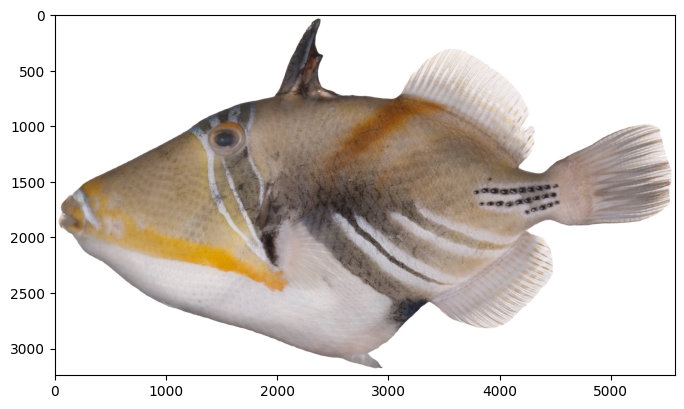

In [2]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import logging
import re
import os.path as osp
import numpy as np
import sys

from tqdm import tqdm
from PIL import Image


img = mmcv.imread('/raid/segmentation_dataset/images/m3f9f60803-e7d1-46c5-a91e-44f56c8962fc.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [3]:
data_root="./"
img_dir = os.path.join(data_root, "images/")
ann_dir = os.path.join(data_root, "annotations/")

## Distribution of traits across train-val-test

In [4]:
# '''
# change the path and filenames
# '''
# with open('./train_label.txt') as f:
#     train_labels = f.readlines()

# with open('./val_label.txt') as f:
#     val_labels = f.readlines()

# with open('./test_label.txt') as f:
#     test_labels = f.readlines()

In [5]:
# train_labels = [i.replace('\n', '') for i in train_labels]
# val_labels = [i.replace('\n', '') for i in val_labels]
# test_labels = [i.replace('\n', '') for i in test_labels]

In [6]:
# print(f"Number of train samples = {len(train_labels)}")
# print(f"Number of val samples = {len(val_labels)}")
# print(f"Number of test samples = {len(test_labels)}")

In [7]:
# train_count = [0]*10
# for label in tqdm(train_labels):
#     uniques = np.unique(np.load('./annotations/'+label.replace('.jpg', '.npy')))
#     for mask in uniques:
#         train_count[mask] += 1

In [8]:
# print(train_count)

In [9]:
# test_count = [0]*10
# for label in tqdm(test_labels):
#     uniques = np.unique(np.load('./annotations/'+label.replace('.jpg', '.npy')))
#     for mask in uniques:
#         test_count[mask] += 1

# val_count = [0]*10
# for label in tqdm(val_labels):
#     uniques = np.unique(np.load('./annotations/'+label.replace('.jpg', '.npy')))
#     for mask in uniques:
#         val_count[mask] += 1

In [10]:
# val_count

In [11]:
# test_count

We need to convert the annotation into semantic map format as an image.

In [12]:
# define class and palette for better visualization

# Background      0
# Head            1
# Eye             2
# Dorsal fin      3
# Pectoral fin    4
# Pelvic fin      5
# Anal fin        6
# Caudal fin      7
# Adipose fin     8
# Barbel          9
classes = ('Background', 'Head', 'Eye', 'Dorsal fin', 'Pectoral fin', 'Pelvic fin', 'Anal fin', 'Caudal fin', 'Adipose fin', 'Barbel')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51],
           [255, 165, 0], [153, 50, 204]]  # Added two new colors

In [13]:
# # convert dataset annotation to semantic segmentation map
# for file in mmengine.scandir(osp.join(data_root, ann_dir)):
#     seg_map = np.load(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#     seg_img = Image.fromarray(seg_map).convert('P')
#     seg_img.putpalette(np.array(palette, dtype=np.uint8))
#     seg_img.save(osp.join('./segmentation_maps', file.replace('.npy', '.png')))

In [14]:
all_files_anno = []
for file in os.listdir('./annotations/'):
    all_files_anno.append(file.replace('.npy', ''))

all_files_img = []
for file in os.listdir('./images/'):
    all_files_img.append(file.replace('.png', ''))

In [15]:
set(all_files_anno).difference(all_files_img)

set()

In [3]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open(os.path.join('./segmentation_maps', all_files_anno[1] +'.png'))
plt.figure(figsize=(18, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

NameError: name 'all_files_anno' is not defined

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [17]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class FishForTraits(BaseSegDataset):
    METAINFO = dict(classes=classes, palette=palette)
    def __init__(self, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [18]:
# Download config and checkpoint files
!mim download mmsegmentation --config segformer_mit-b0_8xb2-160k_ade20k-512x512 --dest .

processing segformer_mit-b0_8xb2-160k_ade20k-512x512...
segformer_mit-b0_512x512_160k_ade20k_20210726_101530-8ffa8fda.pth exists in /home/abhilash22/FishTraitSegmentation
Successfully dumped segformer_mit-b0_8xb2-160k_ade20k-512x512.py to /home/abhilash22/FishTraitSegmentation


In [19]:
mmseg_config_path="../mmsegmentation/"

In [20]:
from mmengine import Config
cfg = Config.fromfile(mmseg_config_path+'configs/segformer/segformer_mit-b0_8xb2-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b0_20220624-7e0fe6dd.pth'
crop_size = (
    512,
    512,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/ade/ADEChallengeData2016'
dataset_type = 'ADE20KDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=16000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cf

In [21]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='LN', requires_grad=True)

# cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (224, 224)
cfg.data_preprocessor.size = cfg.crop_size
# cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.decode_head.pop('in_index', None)

# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 10
# cfg.model.auxiliary_head.num_classes = 10

# Modify dataset type and path
cfg.dataset_type = 'FishForTraits'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 10

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images", seg_map_path='segmentation_maps/')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = cfg.data_root+'train_label.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images", seg_map_path='segmentation_maps/')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = cfg.data_root+'val_label.txt'

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path='segmentation_maps/')
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = cfg.data_root+'test_label.txt'


# Load the pretrained weights
cfg.load_from = 'segformer_mit-b0_512x512_160k_ade20k_20210726_101530-8ffa8fda.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/raid/abhilash/fish_work_dir/SegFormer_ade20k/'

cfg.train_cfg.max_iters = 1000
cfg.train_cfg.val_interval = 20
cfg.default_hooks.logger.interval = 1
cfg.default_hooks.checkpoint.interval = 20

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b0_20220624-7e0fe6dd.pth'
crop_size = (
    224,
    224,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        224,
        224,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = './'
dataset_type = 'FishForTraits'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=20, type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', 

In [22]:
cfg.train_dataloader

{'batch_size': 10,
 'num_workers': 2,
 'persistent_workers': True,
 'sampler': {'type': 'InfiniteSampler', 'shuffle': True},
 'dataset': {'type': 'FishForTraits',
  'data_root': './',
  'data_prefix': {'img_path': 'images', 'seg_map_path': 'segmentation_maps/'},
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'LoadAnnotations'},
   {'type': 'RandomResize',
    'scale': (320, 240),
    'ratio_range': (0.5, 2.0),
    'keep_ratio': True},
   {'type': 'RandomCrop', 'crop_size': (224, 224), 'cat_max_ratio': 0.75},
   {'type': 'RandomFlip', 'prob': 0.5},
   {'type': 'PhotoMetricDistortion'},
   {'type': 'PackSegInputs'}],
  'ann_file': './train_label.txt'}}

In [23]:
cfg.test_dataloader

{'batch_size': 1,
 'num_workers': 4,
 'persistent_workers': True,
 'sampler': {'type': 'DefaultSampler', 'shuffle': False},
 'dataset': {'type': 'FishForTraits',
  'data_root': './',
  'data_prefix': {'img_path': './images/',
   'seg_map_path': 'segmentation_maps/'},
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'Resize', 'scale': (320, 240), 'keep_ratio': True},
   {'type': 'LoadAnnotations'},
   {'type': 'PackSegInputs'}],
  'ann_file': './test_label.txt'}}

In [24]:
cfg.val_dataloader

{'batch_size': 1,
 'num_workers': 4,
 'persistent_workers': True,
 'sampler': {'type': 'DefaultSampler', 'shuffle': False},
 'dataset': {'type': 'FishForTraits',
  'data_root': './',
  'data_prefix': {'img_path': 'images', 'seg_map_path': 'segmentation_maps/'},
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'Resize', 'scale': (320, 240), 'keep_ratio': True},
   {'type': 'LoadAnnotations'},
   {'type': 'PackSegInputs'}],
  'ann_file': './val_label.txt'}}

In [25]:
# import shutil
# from tqdm import tqdm
# img_path='/raid/segmentation_dataset/images/'
# shutil.copyfile('/raid/segmentation_dataset/train_label.txt', './train_label.txt')
# shutil.copyfile('/raid/segmentation_dataset/val_label.txt', './val_label.txt')
# shutil.copyfile('/raid/segmentation_dataset/test_label.txt', './test_label.txt')
# for file in tqdm(os.listdir('./annotations/')):
#     shutil.copyfile(img_path+file.replace('.npy', '.jpg'), './images/'+file.replace('.npy', '.png'))

### Train and Evaluation

In [26]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

06/03 01:23:30 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA TITAN RTX
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 10.2, V10.2.8
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.11.0+cu102
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=comput

/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/03 01:23:34 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/03 01:23:34 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [27]:
# Run the training
runner.train()

06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:lr=6e-05
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:weight_decay=0.0
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:decay_mult=0.0
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:lr=6e-05
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:weight_decay=0.0
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:decay_mult=0.0
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:lr=6e-05
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:weight_decay=0.0
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:decay_mult=0.0
06/03 01:23:35 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): MixVisionTransformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PatchEmbed(
          (projection): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerEncoderLayer(
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attn): EfficientMultiheadAttention(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
              )
              (proj_drop): Dropout(p=0.0, inplace=False)
              (dropout_layer): DropPath()
              (sr): Conv2d(32, 32, kernel_size=(8, 8), stride=(8, 8))
              (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            )
            (norm2): LayerNorm((32,), eps=1e-05, el

In [28]:
def extract_metrics_from_log(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    train_acc=[]
    train_loss=[]
    val_miou=[]
    for line in lines:
        if "Iter(train)" in line:
            loss_match = re.search(r"loss: ([\d\.]+)", line)
            acc_match = re.search(r"decode.acc_seg: ([\d\.]+)", line)
            if loss_match and acc_match:
                loss = loss_match.group(1)
                acc = acc_match.group(1)
                train_loss.append(float(loss))
                train_acc.append(float(acc))
                print(f"Training - Loss: {loss}, Accuracy: {acc}")

        elif "Iter(val)" in line and "[120/120]" in line:  # Assuming evaluation at every 120 iterations (10 epochs)
            aAcc_match = re.search(r"mIoU: ([\d\.]+)", line)
            if aAcc_match:
                aAcc = aAcc_match.group(1)
                val_miou.append(float(aAcc))
                print(f"Validation - mIoU: {aAcc}")
    return train_acc, train_loss, val_miou

# Example usage
log_file_path = './segformer_ade20k_1000epochs.txt'
train_acc, train_loss, val_miou=extract_metrics_from_log(log_file_path)

Training - Loss: 0.2317, Accuracy: 1.9553
Training - Loss: 0.2535, Accuracy: 1.6383
Training - Loss: 0.2558, Accuracy: 3.0331
Training - Loss: 0.2539, Accuracy: 5.0836
Training - Loss: 0.2559, Accuracy: 4.2441
Training - Loss: 0.2578, Accuracy: 2.8350
Training - Loss: 0.2621, Accuracy: 5.2031
Training - Loss: 0.2637, Accuracy: 1.2067
Training - Loss: 0.2657, Accuracy: 0.7602
Training - Loss: 0.2647, Accuracy: 2.8904
Training - Loss: 0.2597, Accuracy: 0.5758
Training - Loss: 0.2581, Accuracy: 2.1082
Training - Loss: 0.2567, Accuracy: 3.1838
Training - Loss: 0.2548, Accuracy: 1.8665
Training - Loss: 0.2570, Accuracy: 5.9678
Training - Loss: 0.2547, Accuracy: 5.9379
Training - Loss: 0.2474, Accuracy: 3.8571
Training - Loss: 0.2470, Accuracy: 4.1546
Training - Loss: 0.2437, Accuracy: 2.4063
Training - Loss: 0.2434, Accuracy: 5.8188
Validation - mIoU: 1.3500
Training - Loss: 0.2486, Accuracy: 18.0360
Training - Loss: 0.2398, Accuracy: 2.8970
Training - Loss: 0.2377, Accuracy: 5.1886
Trainin

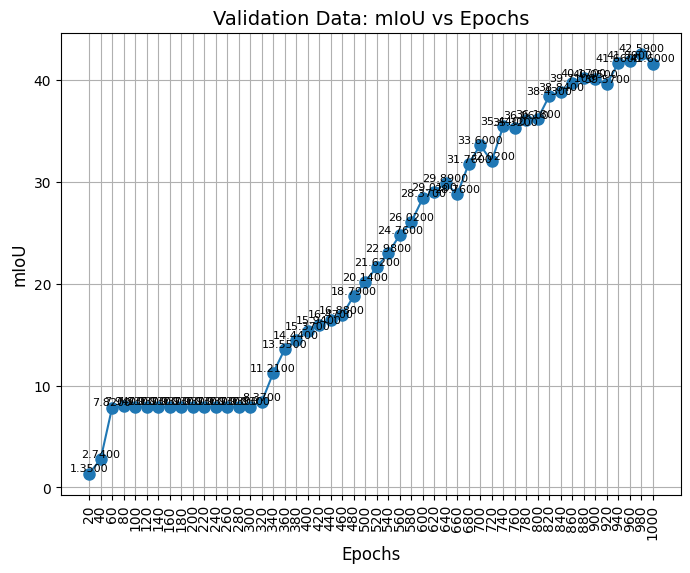

In [29]:
# Convert the mIoU values to float
miou_values = [float(x) for x in val_miou]

# Create a list of epochs
epochs = list(range(20, 1001, 20))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the mIoU values
ax.plot(epochs, miou_values, marker='o', markersize=8, linestyle='-')

# Add markers and labels for y-values
for x, y in zip(epochs, miou_values):
    ax.text(x, y, f'{y:.4f}', fontsize=8, ha='center', va='bottom')

# Set x-ticks and labels
ax.set_xticks(epochs)
plt.xticks(rotation=90)
ax.set_xticklabels(epochs)
plt.grid()

# Set x and y labels
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('mIoU', fontsize=12)

# Set title
ax.set_title('Validation Data: mIoU vs Epochs', fontsize=14)

# Show the plot
plt.show()

In [30]:
best_ckpt_epoch = (np.argmax(val_miou)+1)*20
best_ckpt_epoch

980

In [31]:
best_miou = np.max(val_miou)
best_miou

42.59

In [32]:
'''
rename the best epoch ckpt as 'last_checkpoint.pth'
'''
iter_num = best_ckpt_epoch
log_path = '/raid/abhilash/fish_work_dir/SegFormer_ade20k/'

# Check if this is the last iteration - if yes, then we don't need any renaming
if iter_num != cfg.train_cfg.max_iters//cfg.train_cfg.val_interval:
    # rename last_checkpoint to last_checkpoint_
    last_ckpt_new_filename = 'last_checkpoint_'
    os.rename(os.path.join(log_path, 'last_checkpoint'), os.path.join(log_path, last_ckpt_new_filename))
    
    # Rename the file to 'last_checkpoint.pth'
    new_filename = 'last_checkpoint'
    os.rename(os.path.join(log_path, f'iter_{iter_num}.pth'), os.path.join(log_path, new_filename))
    print(f'Renamed {best_ckpt_epoch} ckpt to {new_filename}')

Renamed 980 ckpt to last_checkpoint


In [33]:
'''
perform testing with the best validation ckpt
'''
runner.test()

06/03 01:49:24 - mmengine - INFO - Iter(test) [  1/600]    eta: 0:07:34  time: 0.7588  data_time: 0.6245  memory: 1096  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  2/600]    eta: 0:04:22  time: 0.4393  data_time: 0.3230  memory: 1097  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  3/600]    eta: 0:03:05  time: 0.3111  data_time: 0.2223  memory: 711  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  4/600]    eta: 0:02:23  time: 0.2400  data_time: 0.1681  memory: 279  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  5/600]    eta: 0:01:56  time: 0.1961  data_time: 0.1355  memory: 196  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  6/600]    eta: 0:01:39  time: 0.1675  data_time: 0.1141  memory: 137  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  7/600]    eta: 0:01:26  time: 0.1461  data_time: 0.0981  memory: 133  
06/03 01:49:24 - mmengine - INFO - Iter(test) [  8/600]    eta: 0:01:16  time: 0.1300  data_time: 0.0862  memory: 104  
06/03 01:49:24 - mmengine - INFO - Ite

{'aAcc': 89.83, 'mIoU': 41.47, 'mAcc': 47.68}

Inference with trained model

/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /raid/abhilash/fish_work_dir/SegFormer_ade20k/last_checkpoint


/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


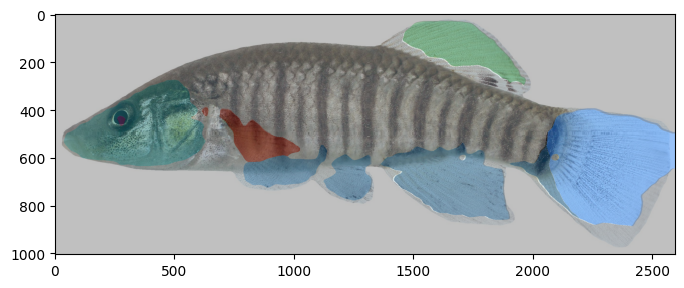

In [34]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/raid/abhilash/fish_work_dir/SegFormer_ade20k/last_checkpoint'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./images/18e704cc-3ee9-4d54-bd6d-1dc2ae27d6bc.png') #sample from test images
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

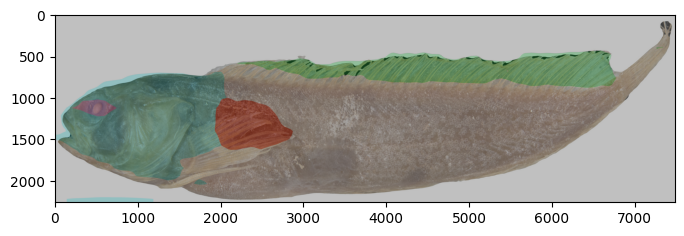

In [35]:
# Init the model from the config and the checkpoint
# checkpoint_path = './fish_work_dir/last_checkpoint'
# model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./images/1543846386268yDHMwobxCZ7DZRHG.png') #sample from test images
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))